In [1]:
%load_ext watermark
%watermark

2019-05-23T14:34:44+01:00

CPython 3.6.8
IPython 7.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-50-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Hemos visto una forma de procesar datasets que no caben en memoria usando pandas. Pese a que ésto funciona, es un proceso manual, ya que nos obliga a gestionar por nuestra cuenta como procesar cada bloque, asi como la gestión de agregaciones.

Para todo esto existe [dask](https://dask.org/), que es una librería diseñada para trabajar con dataframes de pandas (y arrays de numpy) de forma distribuida. Ésto significa que podemos usar dask/pandas tanto en nuestro ordenador con un dataset pequeño como en un cluster (un grupo) de ordenadores con un dataset de Big Data

Al igual que pandas, dask tiene [dataframes](https://docs.dask.org/en/latest/dataframe.html).

La convencion para importar dataframes de dask es:

In [3]:
import dask.dataframe as dd

Leemos el csv de forma similar a pandas:

In [4]:
path_dataset = "../data/nyc_taxi_data_2014.csv"
viajes = dd.read_csv(path_dataset)

In [5]:
viajes

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
npartitions=40,,,,,,,,,,,,,,,,,,
,object,object,object,int64,float64,float64,float64,int64,object,float64,float64,object,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Vemos que no ha imprimido ningun dato.

Esto es asi por que dask usa evaluación "vaga" (lazy evaluation). Esto significa que dask no hace nada a menos que requiramos una operacion que requiere producir un output. 

Por ejemplo, si queremos ver las primeras 5 filas del dataset, podemos hacer:

In [7]:
head = viajes.head(5)
head

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,N,-73.982227,40.731790,CRD,6.5,0.5,0.5,1.40,0.0,8.90
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,N,-73.960449,40.763995,CRD,8.5,0.5,0.5,1.90,0.0,11.40
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,N,-73.986626,40.765217,CRD,11.5,0.5,0.5,1.50,0.0,14.00
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,N,-73.979863,40.777050,CRD,7.5,0.5,0.5,1.70,0.0,10.20
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,N,-73.984367,40.720524,CRD,6.0,0.5,0.5,1.75,0.0,8.75


In [8]:
type(head)

pandas.core.frame.DataFrame

Al hacer `head(5)` dask comprende que tiene que leer el csv, y va a leer **sólo** las primeras 5 filas.

Muchas operaciones son similares a pandas

In [9]:
type(viajes)

dask.dataframe.core.DataFrame

In [10]:
viajes = viajes.rename(columns={
    "vendor_id": "empresa_gestora_pago",
    "pickup_datetime": "hora_recogida",
    "dropoff_datetime": "hora_llegada",
    "passenger_count": "n_pasajeros",
    "trip_distance": "distancia",
    "pickup_longitude": "lon_recogida",
    "pickup_latitude": "lat_recogida",
    "rate_code": "codigo_tarifa",
    "store_and_fwd_flag": "trayecto_almacenaje_en_taxi",
    "dropoff_longitude": "lon_llegada",
    "dropoff_latitude": "lat_llegada",
    "payment_type": "tipo_pago",
    "fare_amount": "tarifa",
    "surcharge": "sobrecarga",
    "mta_tax": "impuestos",
    "tolls_amount": "peajes",
    "total_amount": "coste_total"
})

In [11]:
viajes.head(5)

,empresa_gestora_pago,hora_recogida,hora_llegada,n_pasajeros,distancia,lon_recogida,lat_recogida,codigo_tarifa,trayecto_almacenaje_en_taxi,lon_llegada,lat_llegada,tipo_pago,tarifa,sobrecarga,impuestos,tip_amount,peajes,coste_total
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,N,-73.982227,40.731790,CRD,6.5,0.5,0.5,1.40,0.0,8.90
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,N,-73.960449,40.763995,CRD,8.5,0.5,0.5,1.90,0.0,11.40
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,N,-73.986626,40.765217,CRD,11.5,0.5,0.5,1.50,0.0,14.00
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,N,-73.979863,40.777050,CRD,7.5,0.5,0.5,1.70,0.0,10.20
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,N,-73.984367,40.720524,CRD,6.0,0.5,0.5,1.75,0.0,8.75


Al hacer computación vaga, dask no sabe el tamaño del dataset, asi que funciones de pandas que dependen de todo el dataset tienen que ser computadas (y otras no existen, por ejemplo `.shape`)

In [12]:
viajes.shape

(Delayed('int-e8e8dc37-41f9-4a5e-afe2-3198cf65f6c0'), 18)

podemos ver cuantas filas tienen valores no nulos para cada columna haciendo `.count()`. 

In [14]:
recuento = viajes.count()
recuento

Dask Series Structure:
npartitions=1
codigo_tarifa                  int64
trayecto_almacenaje_en_taxi      ...
dtype: int64
Dask Name: dataframe-count-agg, 201 tasks

vemos que no ha emitido el numero de filas, sino que ha emitido otra cosa

In [15]:
type(recuento)

dask.dataframe.core.Series

para obligar a dask a que en efecto haga los cálculos (recordemos, dask es "vago"), usamos el método `.compute()` (para obligar a hacer la computacion)

Podemos visualizar las operaciones que va a hacer dask con la funcion `visualize()`.

**Nota:** Esta función necesita el paquete `grahpviz` y el paquete `python-graphviz`, al menos en windows

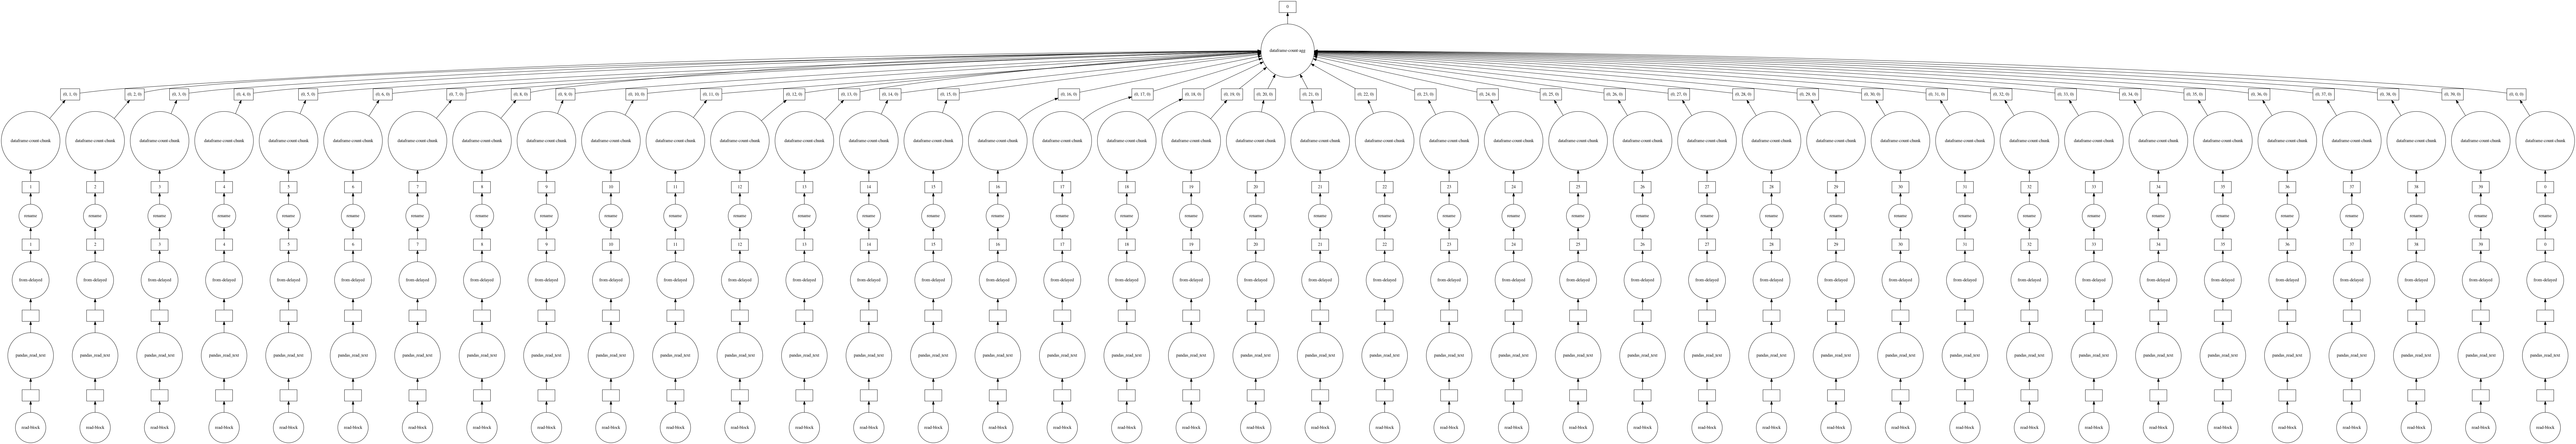

In [16]:
recuento.visualize()

Si hacemos `compute()` dask realiza estas operaciones y nos devuelve el resultado

In [29]:
%%time
n_viajes = viajes.count().compute()

/home/manuel/anaconda3/envs/data/lib/python3.6/site-packages/dask/core.py:118: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


CPU times: user 1min 23s, sys: 2.87 s, total: 1min 26s
Wall time: 38.4 s


In [30]:
n_viajes

empresa_gestora_pago           14999999
hora_recogida                  14999999
hora_llegada                   14999999
n_pasajeros                    14999999
distancia                      14999999
lon_recogida                   14999999
lat_recogida                   14999999
codigo_tarifa                  14999999
trayecto_almacenaje_en_taxi     7363922
lon_llegada                    14999854
lat_llegada                    14999854
tipo_pago                      14999999
tarifa                         14999999
sobrecarga                     14999999
impuestos                      14999999
tip_amount                     14999999
peajes                         14999999
coste_total                    14999999
dtype: int64

vemos que no hay valores nulos y que hay 14,999,999 observaciones, y que la columna `trayecto_almacenaje_en_taxi` tiene valores nulos

Supongamos que queremos saber el porcentaje de trayectos que se pagan con tarjeta

In [31]:
viajes.tipo_pago.value_counts()

Dask Series Structure:
npartitions=1
    int64
      ...
Name: tipo_pago, dtype: int64
Dask Name: value-counts-agg, 246 tasks

Recordemos!, tenemos que usar compute

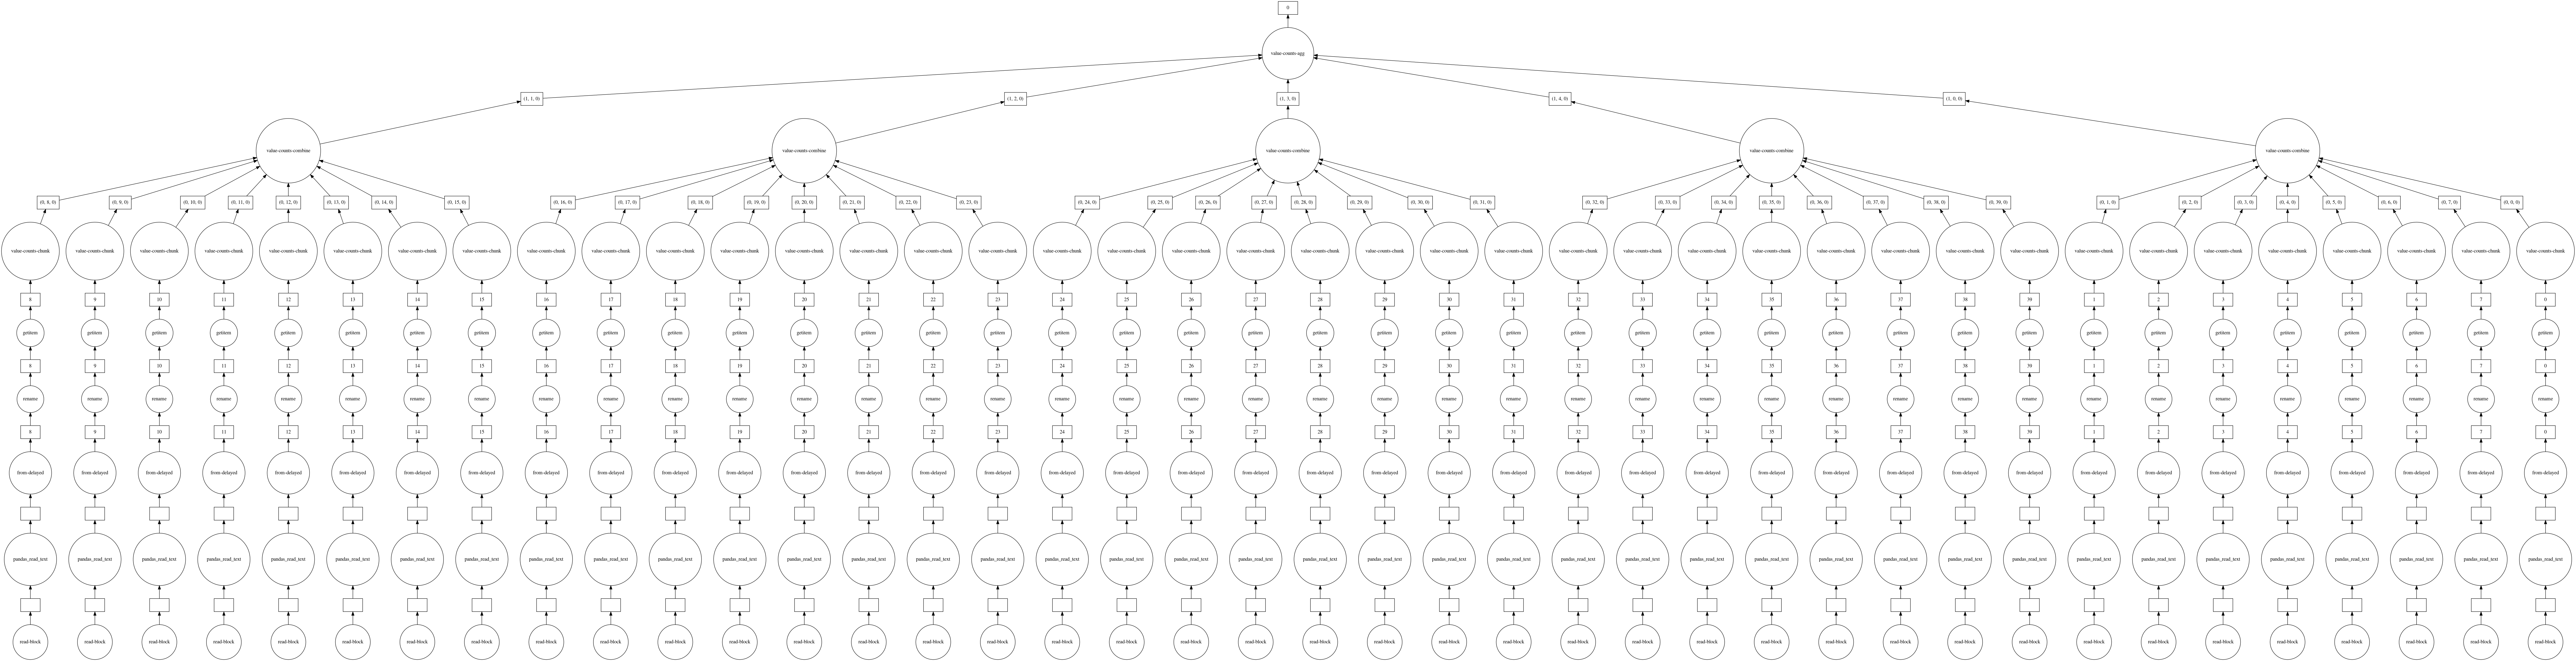

In [32]:
viajes.tipo_pago.value_counts().visualize()

In [33]:
viajes.tipo_pago.value_counts().compute()

/home/manuel/anaconda3/envs/data/lib/python3.6/site-packages/dask/core.py:118: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


CRD    8667410
CSH    6215019
UNK      73983
NOC      33737
DIS       9850
Name: tipo_pago, dtype: int64

vemos que de los 14Millones, 8.6 millones son con tarjeta de crédito y 6.2 millones son en metálico

Supongamos que queremos solo aquellos viajes donde el tipo de pago es desconocido (`tipo_pago == "UNK"`), podemos filtrar como con pandas

In [34]:
pago_unk = viajes[viajes.tipo_pago=="UNK"]

In [35]:
pago_unk

,empresa_gestora_pago,hora_recogida,hora_llegada,n_pasajeros,distancia,lon_recogida,lat_recogida,codigo_tarifa,trayecto_almacenaje_en_taxi,lon_llegada,lat_llegada,tipo_pago,tarifa,sobrecarga,impuestos,tip_amount,peajes,coste_total
npartitions=40,,,,,,,,,,,,,,,,,,
,object,object,object,int64,float64,float64,float64,int64,object,float64,float64,object,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


ahora podemos trabajar con la seleccion que hemos hecho de la misma forma. Por ejemplo, si queremos calcular estadísticos descriptivos para aquellos pagos sin tipo de pago conocido podemos usar `.describe()` igual que con pandas (tarda aproximadamente 1 minuto en mi ordenador).

In [36]:
descripcion = pago_unk.describe().compute()
descripcion

/home/manuel/anaconda3/envs/data/lib/python3.6/site-packages/dask/core.py:118: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


,n_pasajeros,distancia,lon_recogida,lat_recogida,codigo_tarifa,lon_llegada,lat_llegada,tarifa,sobrecarga,impuestos,tip_amount,peajes,coste_total
count,73983.000000,73983.000000,73983.000000,73983.000000,73983.000000,73983.000000,73983.000000,73983.000000,73983.000000,73983.000000,73983.000000,73983.000000,73983.000000
mean,2.127948,2.820328,-73.458924,40.465540,1.015625,-73.418195,40.444136,12.055760,0.309605,0.499277,2.190865,0.198065,15.412063
std,1.723488,2.974668,6.162461,3.394737,0.162930,6.394609,3.522719,8.800009,0.368370,0.019001,1.811237,1.072044,11.006227
min,1.000000,0.000000,-74.857415,0.000000,1.000000,-74.550230,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,1.000000,1.500000,-73.987887,40.738932,1.000000,-73.986425,40.744767,7.000000,0.000000,0.500000,1.260000,0.000000,9.500000
50%,1.000000,2.160000,-73.978111,40.756801,1.000000,-73.977343,40.758216,10.000000,0.500000,0.500000,1.800000,0.000000,13.000000
75%,3.000000,3.942500,-73.957923,40.772231,1.000000,-73.958560,40.774628,15.625000,1.000000,0.500000,2.880000,0.000000,19.595000
max,6.000000,62.690000,0.000000,41.387935,8.000000,0.000000,41.411350,500.000000,1.000000,0.500000,88.890000,19.600000,575.000000


Si pensamos que un dataframe de dask nos va a caber en memoria, podemos convertirlo a un dataframe normal de pandas, simplemente tenemos que hacer `compute()` (el resultado de compute() es siempre una serie de pandas o un dataframe de pandas) 

In [37]:
type(descripcion)

pandas.core.frame.DataFrame

In [38]:
pago_unk_pandas = pago_unk.compute()
type(pago_unk_pandas)

/home/manuel/anaconda3/envs/data/lib/python3.6/site-packages/dask/core.py:118: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


pandas.core.frame.DataFrame

In [39]:
pago_unk_pandas.shape

(73983, 18)

De igual forma que leemos con `read_csv`, podemos escribir con `to_csv`

In [45]:
!mkdir ../data/taxi_2014_unk/

In [46]:
%time pago_unk.to_csv("../data/taxi_2014_unk", index=False)

CPU times: user 1min 23s, sys: 3.77 s, total: 1min 27s
Wall time: 42.3 s


['../data/taxi_2014_unk/00.part',
 '../data/taxi_2014_unk/01.part',
 '../data/taxi_2014_unk/02.part',
 '../data/taxi_2014_unk/03.part',
 '../data/taxi_2014_unk/04.part',
 '../data/taxi_2014_unk/05.part',
 '../data/taxi_2014_unk/06.part',
 '../data/taxi_2014_unk/07.part',
 '../data/taxi_2014_unk/08.part',
 '../data/taxi_2014_unk/09.part',
 '../data/taxi_2014_unk/10.part',
 '../data/taxi_2014_unk/11.part',
 '../data/taxi_2014_unk/12.part',
 '../data/taxi_2014_unk/13.part',
 '../data/taxi_2014_unk/14.part',
 '../data/taxi_2014_unk/15.part',
 '../data/taxi_2014_unk/16.part',
 '../data/taxi_2014_unk/17.part',
 '../data/taxi_2014_unk/18.part',
 '../data/taxi_2014_unk/19.part',
 '../data/taxi_2014_unk/20.part',
 '../data/taxi_2014_unk/21.part',
 '../data/taxi_2014_unk/22.part',
 '../data/taxi_2014_unk/23.part',
 '../data/taxi_2014_unk/24.part',
 '../data/taxi_2014_unk/25.part',
 '../data/taxi_2014_unk/26.part',
 '../data/taxi_2014_unk/27.part',
 '../data/taxi_2014_unk/28.part',
 '../data/taxi

### dask.bag

Hemos visto los dataframes de dask (dask.dataframe), que se usa cuando queremos leer datos estructurados (o semi estructurados, como el formato csv).

Para datos que sean mas desestructurados, podemos usar [`dask.bag`](http://docs.dask.org/en/latest/bag-overview.html), que simplemente implementa funciones comunes a iteradores de python (listas, tuplas, todo lo que se pueda hacer en un bucle `for` ).

Por ejemplo, si recordamos el video de scraping avanzado, escrapeamos un portal de noticias español llamado [meneame](www.meneame.net), y producimos un archivo en formato [jsonlines](http://jsonlines.org/) que contenia una noticia por linea en formato json.  En este caso en particular el dataset es pequeñito, pero funcionaria igual si fuese de millones de noticias.

Podemos leerlo muy facilmente con dask.

In [47]:
!ls -alh ../data/posts.jl

-rwxrwxrwx 1 root root 770K May 14  2018 ../data/posts.jl


In [48]:
import json
import dask.bag as db

In [49]:
noticias = db.read_text("../data/posts.jl")

Un dask.bag no tiene el método `head()` (ya que no es un dataframe), pero tiene el método `.take()` que es similar (básicamente, nos permite "tomar" los n primeros elementos de un dataset)

In [50]:
noticias.take(1)

('{"url": "https://es.gizmodo.com/dos-luchadores-profesionales-explican-por-que-las-tipic-1826003946", "titular": "Dos luchadores profesionales explican por qué las típicas técnicas de autodefensa no sirven para nada", "n_comentarios": "19 comentarios", "karma": "439", "descripcion": "Internet está lleno de vídeos que enseñan técnicas de defensa personal en el caso de que alguien nos asalte. El experto en artes marciales Ramsey Dewey ha decidido comprobar qué ocurre cuando alguien trata de poner en práctica esas técnicas contra un asaltante que opone resistencia.", "n_meneos": "22", "n_clics": "530 clics", "votos_positivos": "17", "votos_negativos": "0", "votos_anonimos": "5", "sub": "ocio", "usuario": "Thornton", "timestamp": "1526310535"}\n',)

Vemos que devuelve un string con los datos json. Para convertir dicho string simplemente tenemos que usar json.loads. Lo aplicamos al db.bag mediante la funcion `map()`:

In [51]:
noticias = noticias.map(json.loads)

In [52]:
noticias

dask.bag<loads-9..., npartitions=1>

In [53]:
noticias.take(1)

({'url': 'https://es.gizmodo.com/dos-luchadores-profesionales-explican-por-que-las-tipic-1826003946',
  'titular': 'Dos luchadores profesionales explican por qué las típicas técnicas de autodefensa no sirven para nada',
  'n_comentarios': '19 comentarios',
  'karma': '439',
  'descripcion': 'Internet está lleno de vídeos que enseñan técnicas de defensa personal en el caso de que alguien nos asalte. El experto en artes marciales Ramsey Dewey ha decidido comprobar qué ocurre cuando alguien trata de poner en práctica esas técnicas contra un asaltante que opone resistencia.',
  'n_meneos': '22',
  'n_clics': '530 clics',
  'votos_positivos': '17',
  'votos_negativos': '0',
  'votos_anonimos': '5',
  'sub': 'ocio',
  'usuario': 'Thornton',
  'timestamp': '1526310535'},)

el método `pluck` coge claves de cada diccionario, por ejemplo si queremos coger solo la clave "url" de cada post (tambien coge elementos de arrays):

In [54]:
noticias.pluck(["titular", "url"]).take(10)

(('Dos luchadores profesionales explican por qué las típicas técnicas de autodefensa no sirven para nada',
  'https://es.gizmodo.com/dos-luchadores-profesionales-explican-por-que-las-tipic-1826003946'),
 ('Una de las alumnas declara ante la jueza que nunca vio a Cifuentes en las clases del máster',
  'https://www.eldiario.es/politica/caso-Master-Cifuentes_0_770973241.html'),
 ('"Suicidal Tendencies" en Cuba: el punk burla el embargo',
  'https://es.noticias.yahoo.com/suicidal-tendencies-en-cuba-el-punk-burla-el-153322582.html'),
 ('Israel masacra a decenas de palestinos en la víspera del 70 aniversario de la Nakba',
  'https://www.elsaltodiario.com/ocupacion-israeli/israel-masacra-decenas-palestinos-vispera-70-aniversario-nakba'),
 ('De cómo un pez sobrevivió en el culo de un pepino de mar [ENG]',
  'http://phenomena.nationalgeographic.com/2016/05/10/how-this-fish-survives-in-a-sea-cucumbers-bum/'),
 ('Muñoz Castellanos: las fotos inéditas del teniente que murió en Bosnia al llevar san

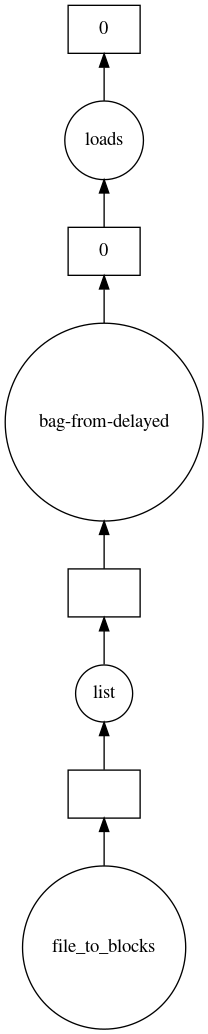

In [55]:
noticias.visualize()

Podemos hacer `count()` tambien

In [56]:
%time noticias.count().compute()

CPU times: user 0 ns, sys: 644 ms, total: 644 ms
Wall time: 674 ms


925

Podemos convertir un dask.bag a un dataframe

In [57]:
noticias_dd = noticias.to_dataframe()
noticias_dd

,descripcion,karma,n_clics,n_comentarios,n_meneos,sub,timestamp,titular,url,usuario,votos_anonimos,votos_negativos,votos_positivos
npartitions=1,,,,,,,,,,,,,
,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [58]:
noticias_dd.head()

,descripcion,karma,n_clics,n_comentarios,n_meneos,sub,timestamp,titular,url,usuario,votos_anonimos,votos_negativos,votos_positivos
0,Internet está lleno de vídeos que enseñan técn...,439,530 clics,19 comentarios,22,ocio,1526310535,Dos luchadores profesionales explican por qué ...,https://es.gizmodo.com/dos-luchadores-profesio...,Thornton,5,0,17
1,Ha explicado que a clase solo iban una decena ...,352,244 clics,20 comentarios,119,actualidad,1526292286,Una de las alumnas declara ante la jueza que n...,https://www.eldiario.es/politica/caso-Master-C...,Cubillina,43,2,76
2,"El salón rosado de La Tropical, catedral del s...",466,266 clics,12 comentarios,44,cultura,1526179416,"""Suicidal Tendencies"" en Cuba: el punk burla e...",https://es.noticias.yahoo.com/suicidal-tendenc...,bonobo,13,2,31
3,Más de 40 palestinos muertos y 2.000 heridos e...,355,328 clics,70 comentarios,191,actualidad,1526308004,Israel masacra a decenas de palestinos en la v...,https://www.elsaltodiario.com/ocupacion-israel...,Sandra_,95,16,96
4,"En 1975, Victor Benno Meyer-Rochow se sumergió...",406,1237 clics,19 comentarios,44,cultura,1526303484,De cómo un pez sobrevivió en el culo de un pep...,http://phenomena.nationalgeographic.com/2016/0...,exexexexmeneante,13,1,31


Una utilidad muy práctica de dask es que puede leer de multiples archivos a la vez. Tenemos en la carpeta data una subcarpeta llamada `reddit` que tiene varios archivos json lines, uno con posts para cada subreddit.

Podemos leerlos todos a la vez (siempre que tengan el mismo schema) con dask de forma sencilla

In [59]:
ls -alh ../data/reddit/

total 2.9G
drwxrwxrwx 1 root root 4.0K May 23 14:43 ./
drwxrwxrwx 1 root root 4.0K May 23 14:56 ../
-rwxrwxrwx 1 root root 293M May 23 14:43 reddit_askhistorians.jsonl*
-rwxrwxrwx 1 root root 227M May 23 14:43 reddit_askreddit.jsonl*
-rwxrwxrwx 1 root root 117M May 23 14:44 reddit_askscience.jsonl*
-rwxrwxrwx 1 root root 300M May 23 14:42 reddit_datascience.jsonl*
-rwxrwxrwx 1 root root 300M May 23 14:43 reddit_IAmA.jsonl*
-rwxrwxrwx 1 root root 450M May 23 14:42 reddit_machinelearning.jsonl*
-rwxrwxrwx 1 root root 232M May 23 14:43 reddit_news.jsonl*
-rwxrwxrwx 1 root root 342M May 23 14:41 reddit_python.jsonl*
-rwxrwxrwx 1 root root 325M May 23 14:42 reddit_statistics.jsonl*
-rwxrwxrwx 1 root root 369M May 23 14:43 reddit_whowouldwin.jsonl*


In [18]:
import dask.bag as db
import json

In [62]:
reddit = db.read_text("../data/reddit/*.jsonl").map(json.loads).to_dataframe()

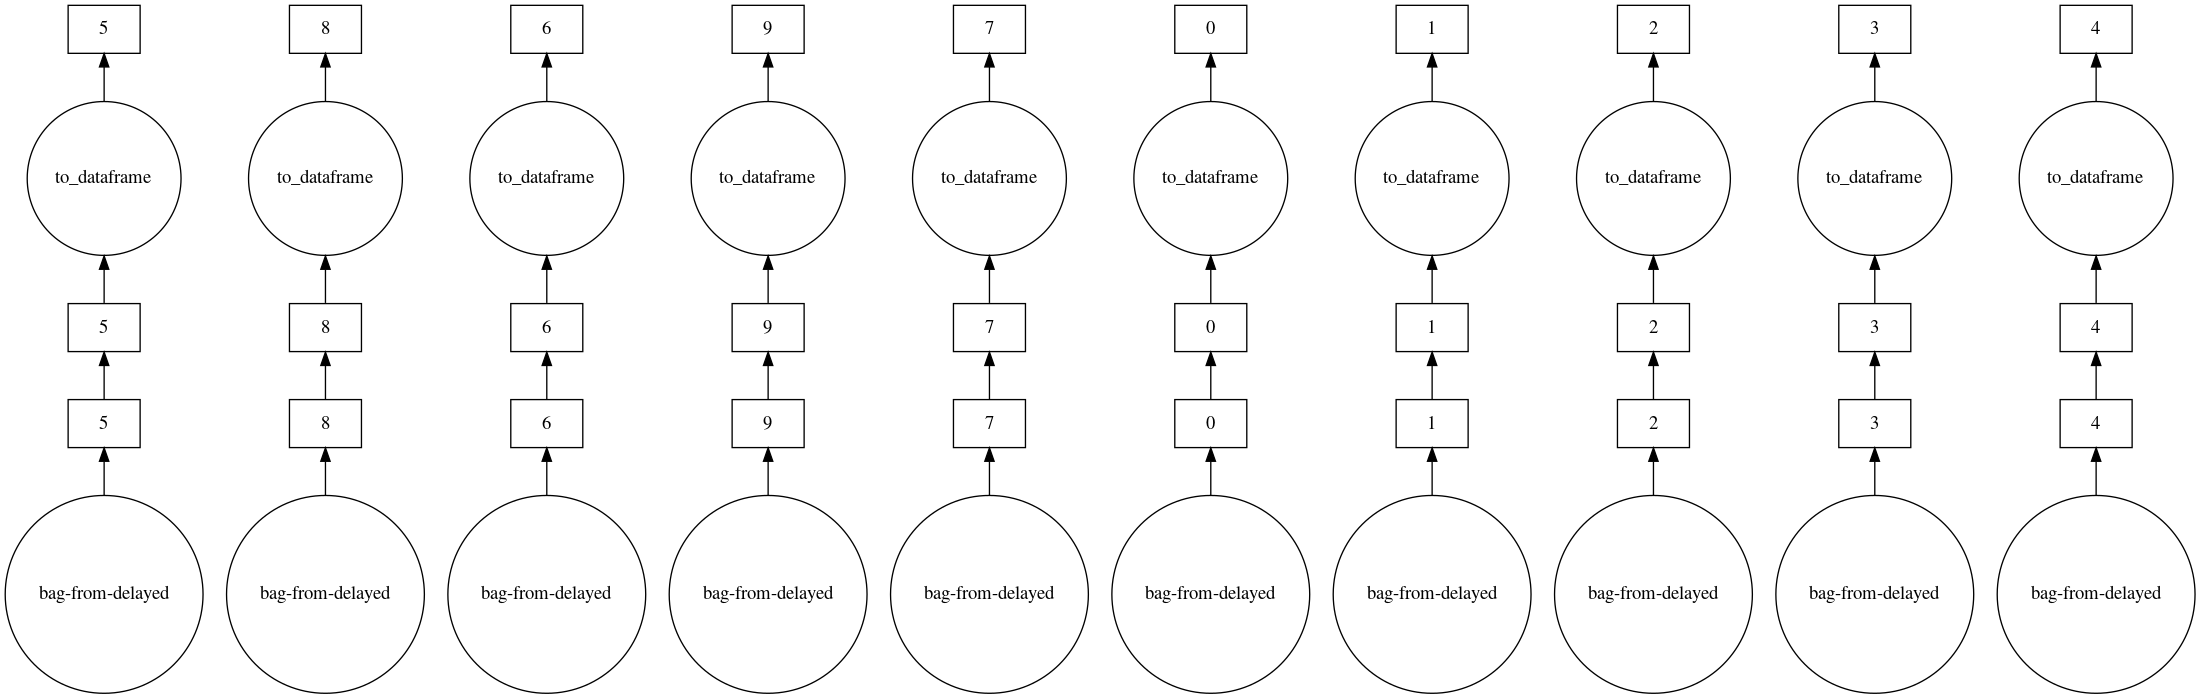

In [63]:
reddit.visualize()

In [65]:
reddit.columns

Index(['all_awardings', 'approved_at_utc', 'approved_by', 'archived', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'banned_at_utc', 'banned_by',
       'can_gild', 'can_mod_post', 'category', 'clicked', 'content_categories',
       'contest_mode', 'created', 'created_utc', 'distinguished', 'domain',
       'downs', 'edited', 'gilded', 'gildings', 'hidden', 'hide_score', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'likes', 'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_text', 'link_flair_text_color',
       'link_flair_type', 'locked', 'media', 'media_embed', 'media_only',
       'mod_note', 'mod_reason_by', 'mod_reaso

In [64]:
reddit.head() 

,all_awardings,approved_at_utc,approved_by,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,...,thumbnail_width,title,total_awards_received,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,[],None,None,False,BusinessInsider,None,None,[],None,None,...,None,"My name is Benjamin Zhang, and I’m a transport...",0,2999,https://www.reddit.com/r/IAmA/comments/blssl3/...,[],None,False,all_ads,6
1,"[{'is_enabled': True, 'count': 1, 'subreddit_i...",None,None,False,RayTDalio,None,None,[],None,None,...,None,I’m Ray Dalio – founder of Bridgewater Associa...,3,3067,https://www.reddit.com/r/IAmA/comments/blv3r8/...,[],None,False,all_ads,6
2,[],None,None,False,12NewsArizona,None,None,[],None,None,...,None,"We are Will Pitts and Kaite Wilcox, an investi...",0,102,https://www.reddit.com/r/IAmA/comments/blssjb/...,[],None,False,all_ads,6
3,[],None,None,False,KimikoIshizaka,None,None,[],None,None,...,None,"My name is Kimiko Ishizaka, and I'm a composer...",0,14,https://www.reddit.com/r/IAmA/comments/blunp2/...,[],None,False,all_ads,6
4,[],None,None,False,Sotuiofficial,None,None,[],None,None,...,None,"Hello, I am SOTUI, music producer for world-le...",0,4,https://www.reddit.com/r/IAmA/comments/bm3r9z/...,[],None,False,all_ads,6


In [66]:
posts_por_subreddit = reddit.subreddit.value_counts()

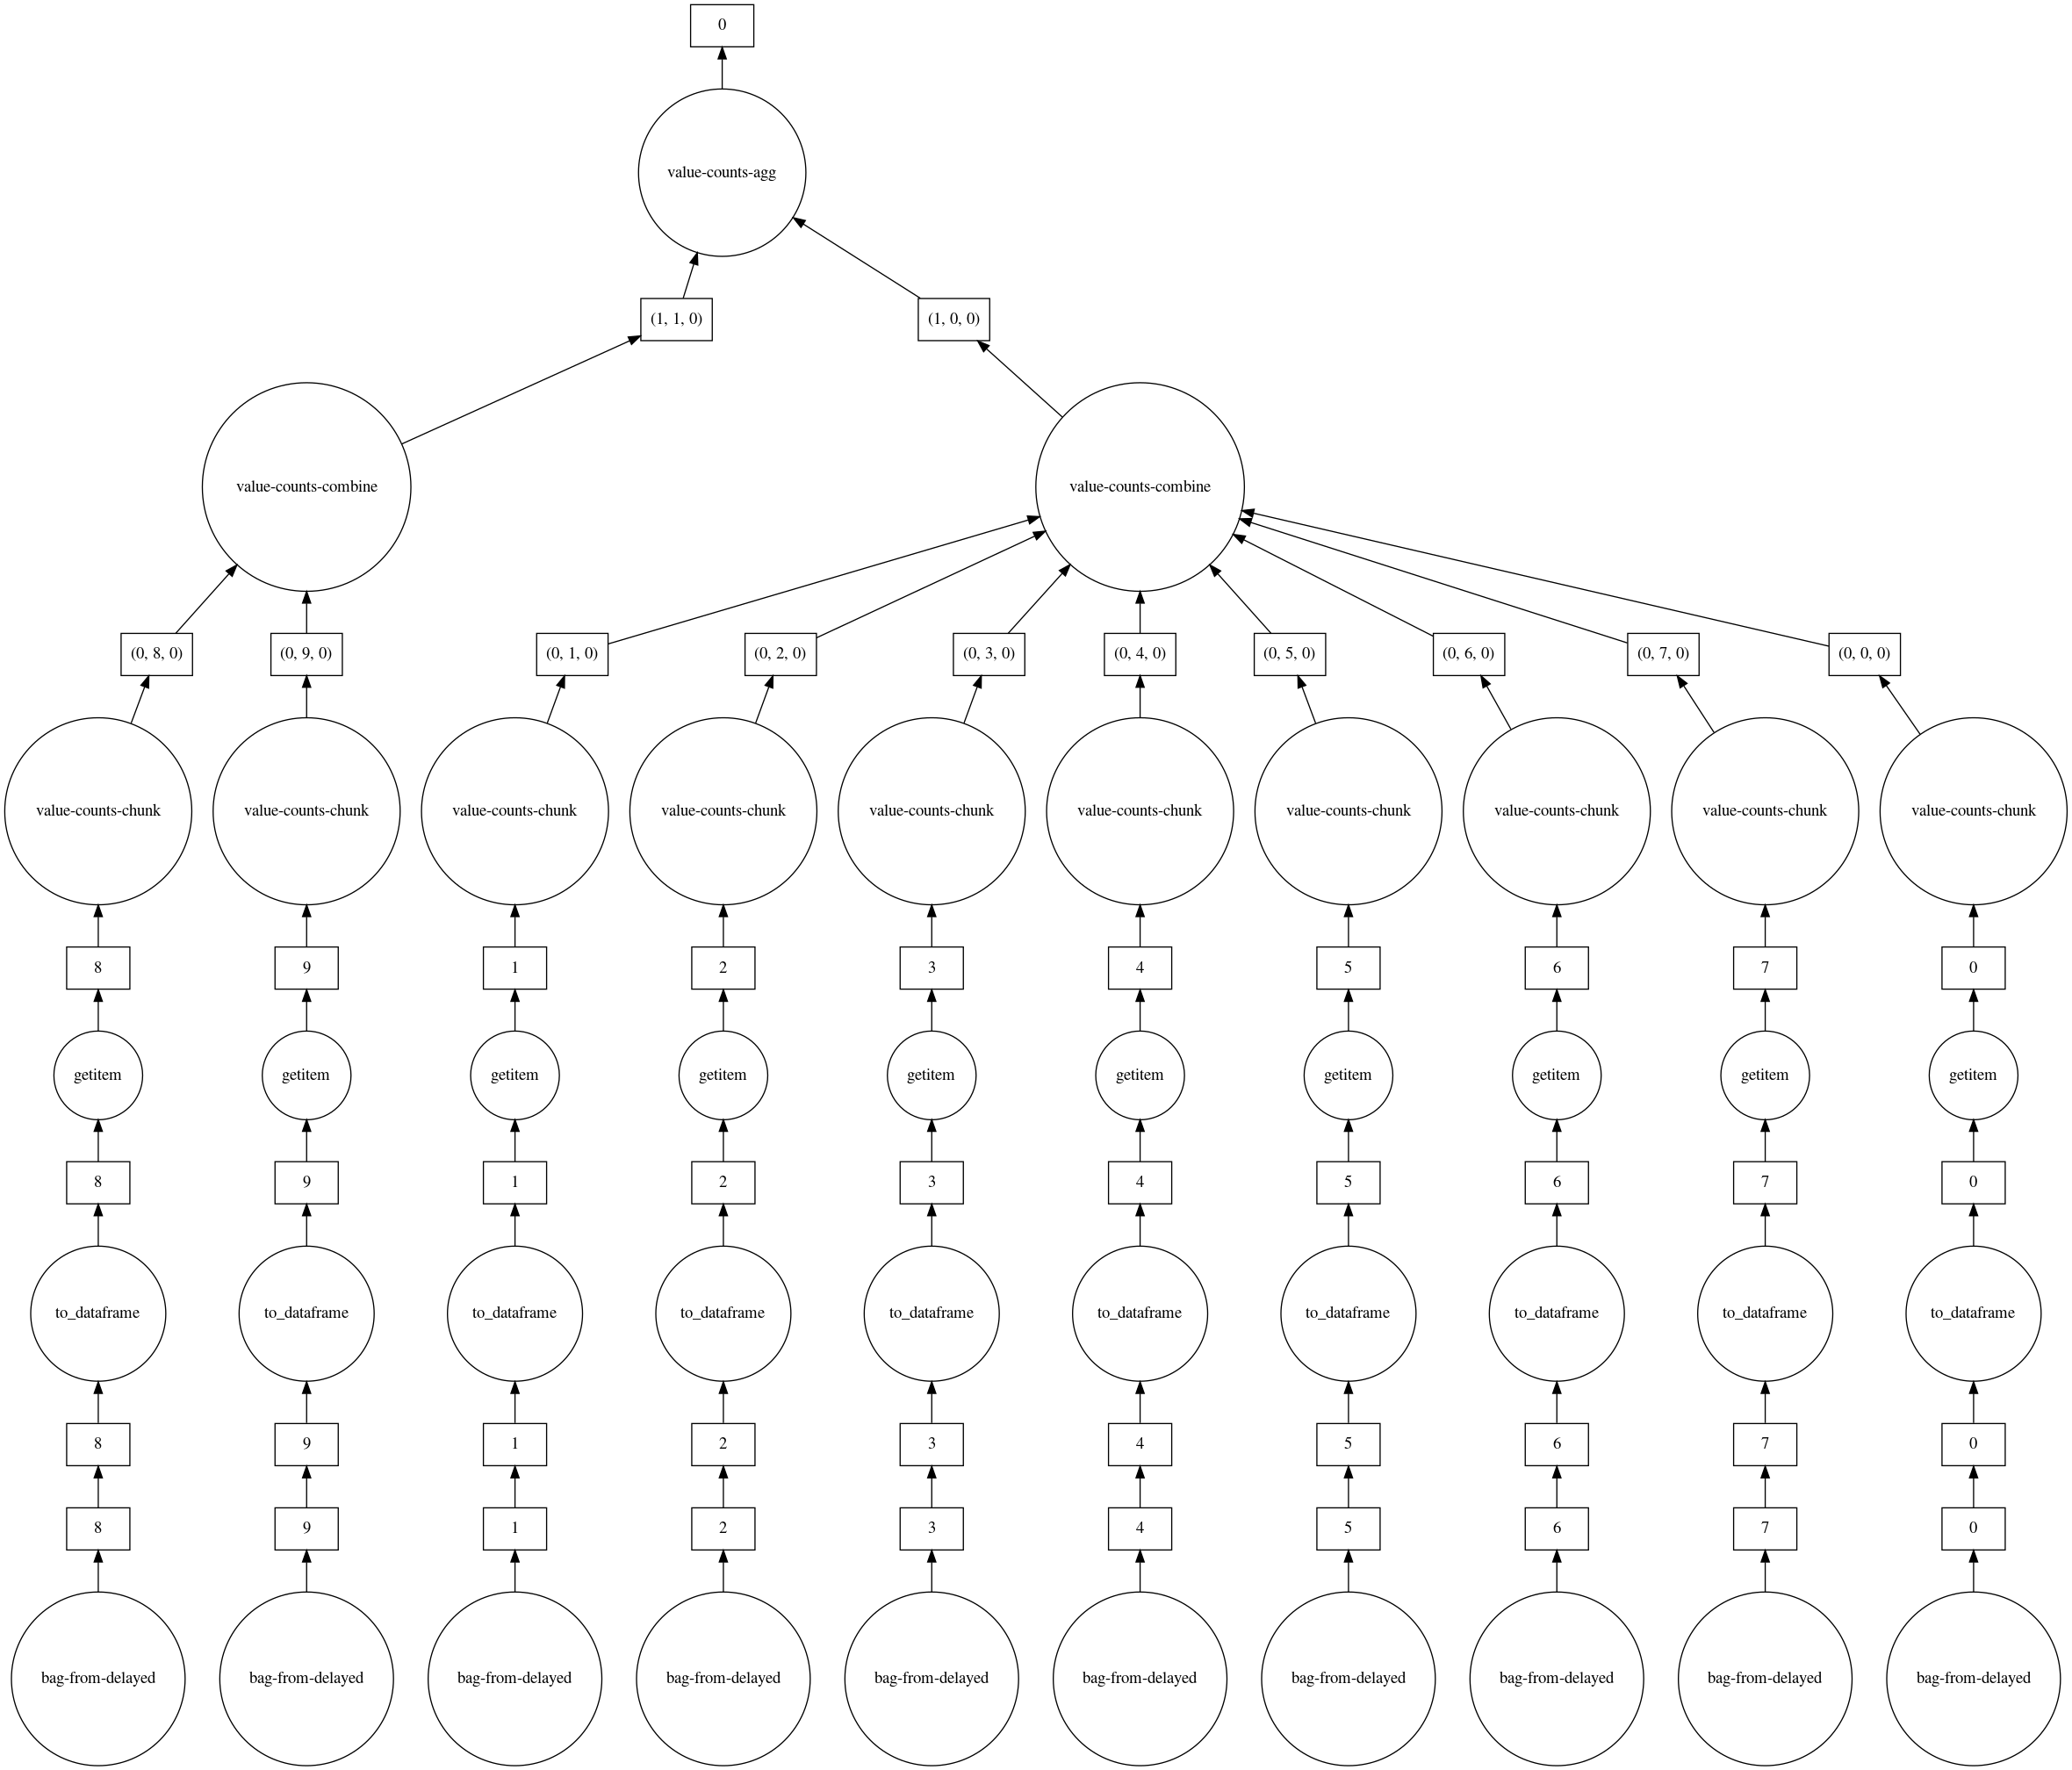

In [67]:
posts_por_subreddit.visualize()

In [68]:
%%time
posts_por_subreddit_df = posts_por_subreddit.compute()

CPU times: user 2min 21s, sys: 10.2 s, total: 2min 31s
Wall time: 2min 28s


In [70]:
posts_por_subreddit_df

Python             100294
AskReddit          100038
news               100022
whowouldwin        100018
MachineLearning    100010
AskHistorians       97236
statistics          90248
datascience         79708
IAmA                48856
askscience          37989
Name: subreddit, dtype: int64

In [71]:
reddit.npartitions

10

## dask.array

De la misma forma que dask extiende la figura de los dataframes de pandas para datasets medianamente grandes, también tiene la figura del array, que extiende el array de numpy de igual forma

In [72]:
import dask.array as da
import numpy as np

In [73]:
npy_arr = np.random.random(1000)
dask_arr = da.from_array(npy_arr)

In [74]:
dask_arr

dask.array<array, shape=(1000,), dtype=float64, chunksize=(1000,)>

Cuando creamos un array de dask, el array tiene que separarse en bloques `chunks`, para poder ser paralelizado

In [75]:
dask_arr.chunks

((1000,),)

In [81]:
dask_arr = da.from_array(npy_arr, chunks=100)

In [82]:
dask_arr.chunks

((100, 100, 100, 100, 100, 100, 100, 100, 100, 100),)

In [83]:
dask_arr.chunksize

(100,)

Podemos usar funciones similares a numpy, teniendo siempre en cuenta que dask funciona de forma vaga.

In [84]:
op_sum = dask_arr.sum()
op_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

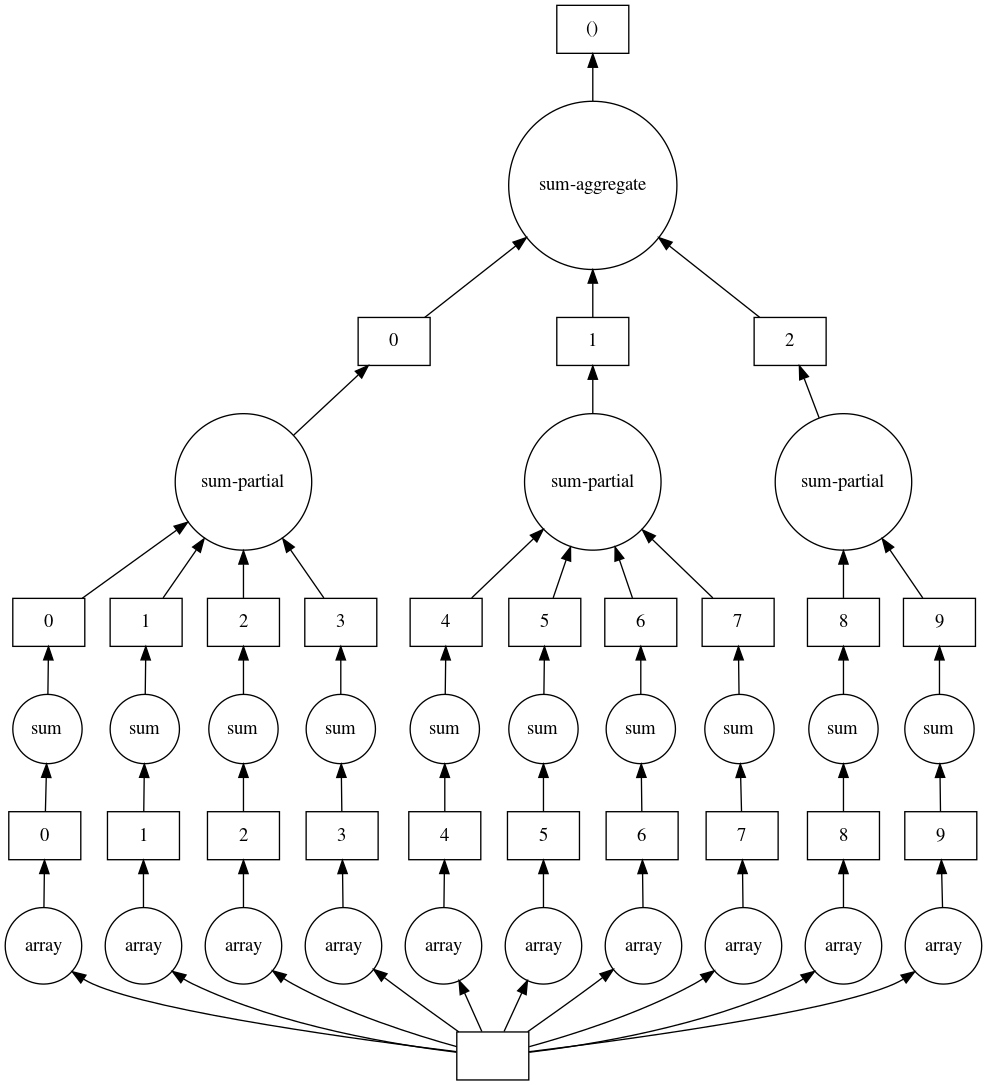

In [85]:
op_sum.visualize()

In [86]:
op_sum.compute()

498.3382251589265

## Datasets de medium data

Ahora vamos a trabajar con un dataset medianamente grande, ocupa 10.5 GB en disco duro

In [87]:
!ls -lah ../data/

total 13G
drwxrwxrwx 1 root root 4.0K May 23 14:56 .
drwxrwxrwx 1 root root 4.0K May 21 16:38 ..
drwxrwxrwx 1 root root  64K May 22 11:47 2017_Yellow_Taxi_Trip_Data.2.parquet
-rwxrwxrwx 1 root root 9.9G Feb  1 13:49 2017_Yellow_Taxi_Trip_Data.csv
drwxrwxrwx 1 root root  32K Feb 19 10:12 2017_Yellow_Taxi_Trip_Data.parquet
drwxrwxrwx 1 root root 8.0K Mar  4 09:43 coste_npasajeros_2017.csv
-rwxrwxrwx 1 root root 2.4G Jul 20  2017 nyc_taxi_data_2014.csv
drwxrwxrwx 1 root root 8.0K May 21 19:49 nyc_taxi_data_2014.parquet
-rwxrwxrwx 1 root root 770K May 14  2018 posts.jl
drwxrwxrwx 1 root root 4.0K May 23 14:43 reddit
-rwxrwxrwx 1 root root 765M May 23 11:08 taxi_2014_en_metalico.csv
drwxrwxrwx 1 root root  432 May 23 14:57 taxi_2014_unk


Vamos a trabajar con el archivo `2017_Yellow_Taxi_Trip_Data.csv` que contiene informacion sobre TODOS los trayectos de taxis en 2017 en Nueva York. Este archivo ocupa 9.9 gigabytes, lo podeis descargar en [la pagina oficial](https://data.cityofnewyork.us/Transportation/2017-Yellow-Taxi-Trip-Data/biws-g3hs), dandole a la opcion *export*.

Dask está diseñado para trabajar en clusters de muchas máquinas. En concreto el módulo [`dask.distributed`](http://distributed.dask.org/en/latest/) permite trabajar desde nuestro ordenador pero procesar datos usando un cluster de dask (que no es más que un conjunto de máquinas interconectadas).

Nosotros lo vamos a probar en local, es decir en nuestro ordenador, pero el proceso seria similar si tuviesemos un cluster de dask, que no es más que un conjunto de ordenadores (en la nube) trabajando conjuntamente.

In [88]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45061 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.50 GB


Ahora podemos ir en nuestro navegador a http://127.0.0.1:8787/status para ver el estado de nuestro *"cluster"* (que solo tiene una máquina, nuestro ordenador)

In [89]:
taxi_grande = (dd
        .read_csv("../data/2017_Yellow_Taxi_Trip_Data.csv", 
                  dtype={'RatecodeID': 'object',
                         'passenger_count': 'float64',
                         'payment_type': 'float64'})
        .rename(columns={
                    "vendor_id": "empresa_gestora_pago",
                    "pickup_datetime": "hora_recogida",
                    "dropoff_datetime": "hora_llegada",
                    "passenger_count": "n_pasajeros",
                    "trip_distance": "distancia",
                    "pickup_longitude": "lon_recogida",
                    "pickup_latitude": "lat_recogida",
                    "rate_code": "codigo_tarifa",
                    "store_and_fwd_flag": "trayecto_almacenaje_en_taxi",
                    "dropoff_longitude": "lon_llegada",
                    "dropoff_latitude": "lat_llegada",
                    "payment_type": "tipo_pago",
                    "fare_amount": "tarifa",
                    "surcharge": "sobrecarga",
                    "mta_tax": "impuestos",
                    "tolls_amount": "peajes",
                    "total_amount": "coste_total"
                })
)

Vamos a calcular cuantas filas no nulas tiene el dataset

In [90]:
%time taxi_grande.count().compute()

CPU times: user 45.7 s, sys: 5.42 s, total: 51.1 s
Wall time: 8min 54s


VendorID                       113496874
tpep_pickup_datetime           113496874
tpep_dropoff_datetime          113496874
n_pasajeros                    113496874
distancia                      113496874
RatecodeID                     113496874
trayecto_almacenaje_en_taxi    113496874
PULocationID                   113496874
DOLocationID                   113496874
tipo_pago                      113496874
tarifa                         113496874
extra                          113496874
impuestos                      113496874
tip_amount                     113496874
peajes                         113496874
improvement_surcharge          113496874
coste_total                    113496873
dtype: int64

Vemos que en mi ordenador ha tardado 9 minutos. Esto es bastante bueno, teniendo en cuenta que son 10 GB de archivo en el disco duro que tienen que leerse y procesarse.

In [91]:
taxi_grande.tipo_pago.head()

0    1.0
1    2.0
2    1.0
3    1.0
4    1.0
Name: tipo_pago, dtype: float64

Vemos que en el dataset original la variable tipo de pago es numerica, el valor de tipo de pago desconocido es 3, vamos a ver cuanto se tarda en hacer el calculo que hemos hecho antes (calcular estadisticos descriptivos para pagos desconocidos)

In [92]:
%%time
pago_unk = taxi_grande[taxi_grande.tipo_pago==3.0]

CPU times: user 31.9 s, sys: 2.52 s, total: 34.5 s
Wall time: 2min 24s


In [ ]:
pago_unk.describe().compute()

Ha tardado un minuto 20 segundos en mi ordenador.

### Parquet
Hemos visto que dask funciona muy bien con archivos csv, pero vamos a ver que cambiando de formato los datos en el disco duro (es decir, pasando de csv a otro tipo) podemos mejorar su eficiencia.

Un formato que es muy eficiente para almacenar datasets en disco duro es [parquet](https://github.com/apache/parquet-format). Dask soporta la escritura en este formato (requiere los paquetes [fastparquet](https://github.com/dask/fastparquet) o [pyarrow](https://arrow.apache.org/docs/python/)).

**NOTA** Parquet es un formato que no es tan flexible con los tipos de datos (dtypes) como pandas. Por eso, es recomendable el especificar los tipos de datos como he hecho arriba al leer del csv. Sin poner estos tipos de datos, la conversion a parquet falla dado que hay una columna que parece numerica pero no lo es.

Escribimos un dask.dataframe a parquet con `to_parquet`:

In [94]:
%time taxi_grande.to_parquet("../data/2017_Yellow_Taxi_Trip_Data.parquet")

CPU times: user 20 s, sys: 2.53 s, total: 22.5 s
Wall time: 3min 2s


Este dataset esta compuesto de muchos archivos de formato parquet.

In [95]:
!ls -alh ../data/2017_Yellow_Taxi_Trip_Data.parquet/

total 3.2G
drwxrwxrwx 1 root root  304 May 23 15:35 .
drwxrwxrwx 1 root root 4.0K May 23 15:32 ..
-rwxrwxrwx 1 root root 2.1K May 23 15:35 _common_metadata
-rwxrwxrwx 1 root root 291K May 23 15:35 _metadata
-rwxrwxrwx 1 root root  21M May 23 15:33 part.0.parquet
-rwxrwxrwx 1 root root  19M May 23 15:34 part.100.parquet
-rwxrwxrwx 1 root root  19M May 23 15:33 part.101.parquet
-rwxrwxrwx 1 root root  19M May 23 15:33 part.102.parquet
-rwxrwxrwx 1 root root  19M May 23 15:33 part.103.parquet
-rwxrwxrwx 1 root root  19M May 23 15:34 part.104.parquet
-rwxrwxrwx 1 root root  19M May 23 15:34 part.105.parquet
-rwxrwxrwx 1 root root  19M May 23 15:32 part.106.parquet
-rwxrwxrwx 1 root root  19M May 23 15:34 part.107.parquet
-rwxrwxrwx 1 root root  19M May 23 15:33 part.108.parquet
-rwxrwxrwx 1 root root  19M May 23 15:32 part.109.parquet
-rwxrwxrwx 1 root root  21M May 23 15:33 part.10.parquet
-rwxrwxrwx 1 root root  19M May 23 15:33 part.110.parquet
-rwxrwxrwx 1 root root  19M May 23 15:33 p

Ahora que está en parquet podemos leerlo bastante rapido, por ejemplo podemos hacer la misma computacion que hemos hecho antes (el calcular los estadisticos descriptivos de aquellos viajes con tipo de pago desconocido).

Vemos que dask puede leer de **multiples archivos a la vez** de forma facil simplemente usando asteriscos en el nombre!

In [96]:
taxi_grande = (dd
               .read_parquet("../data/2017_Yellow_Taxi_Trip_Data.parquet/*.parquet")
               .rename(columns={
                    "vendor_id": "empresa_gestora_pago",
                    "pickup_datetime": "hora_recogida",
                    "dropoff_datetime": "hora_llegada",
                    "passenger_count": "n_pasajeros",
                    "trip_distance": "distancia",
                    "pickup_longitude": "lon_recogida",
                    "pickup_latitude": "lat_recogida",
                    "rate_code": "codigo_tarifa",
                    "store_and_fwd_flag": "trayecto_almacenaje_en_taxi",
                    "dropoff_longitude": "lon_llegada",
                    "dropoff_latitude": "lat_llegada",
                    "payment_type": "tipo_pago",
                    "fare_amount": "tarifa",
                    "surcharge": "sobrecarga",
                    "mta_tax": "impuestos",
                    "tolls_amount": "peajes",
                    "total_amount": "coste_total"
                })
              )

In [97]:
taxi_grande.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,n_pasajeros,distancia,RatecodeID,trayecto_almacenaje_en_taxi,PULocationID,DOLocationID,tipo_pago,tarifa,extra,impuestos,tip_amount,peajes,improvement_surcharge,coste_total
0,2,07/14/2017 11:52:17 PM,07/15/2017 12:26:27 AM,1.0,6.62,1,N,230,116,1.0,27.5,0.5,0.5,2.20,0.0,0.3,31.00
1,1,07/14/2017 11:18:35 PM,07/14/2017 11:30:45 PM,1.0,1.10,1,N,50,164,2.0,9.0,0.5,0.5,0.00,0.0,0.3,10.30
2,1,07/14/2017 11:14:23 PM,07/14/2017 11:35:33 PM,1.0,4.30,1,N,113,143,1.0,18.0,0.5,0.5,2.00,0.0,0.3,21.30
3,1,07/14/2017 11:05:17 PM,07/14/2017 11:21:24 PM,3.0,1.50,1,N,79,164,1.0,11.0,0.5,0.5,2.45,0.0,0.3,14.75
4,1,07/14/2017 11:52:02 PM,07/15/2017 12:07:10 AM,1.0,2.70,1,N,79,162,1.0,12.0,0.5,0.5,0.00,0.0,0.3,13.30


este dataset está partido en muchos trozos o **particiones**. En concreto, tiene una particion por cada archivo `.parquet` distinto.

Esto permite el poder leer multiples partes del dataset en paralelo.

In [98]:
taxi_grande.npartitions

165

Vamos a ver cuanto tarda ahora la misma operacion leyendo de parquet

In [99]:
%time taxi_grande.count().compute()

CPU times: user 12.3 s, sys: 1.19 s, total: 13.5 s
Wall time: 1min 10s


VendorID                       113496874
tpep_pickup_datetime           113496874
tpep_dropoff_datetime          113496874
n_pasajeros                    113496874
distancia                      113496874
RatecodeID                     113496874
trayecto_almacenaje_en_taxi    113496874
PULocationID                   113496874
DOLocationID                   113496874
tipo_pago                      113496874
tarifa                         113496874
extra                          113496874
impuestos                      113496874
tip_amount                     113496874
peajes                         113496874
improvement_surcharge          113496874
coste_total                    113496873
dtype: int64

Vemos que ha tardado de 9 minutos a 1 minuto!

Veamos ahora cuanto tarda el filtrado de pago desconocido

In [101]:
pago_unk = taxi_grande[taxi_grande.tipo_pago==3.0]

In [102]:
%time pago_unk.describe().compute()

CPU times: user 35.9 s, sys: 1.54 s, total: 37.4 s
Wall time: 1min 18s


,VendorID,n_pasajeros,distancia,PULocationID,DOLocationID,tipo_pago,tarifa,extra,impuestos,tip_amount,peajes,improvement_surcharge,coste_total
count,599001.000000,599001.000000,599001.000000,599001.000000,599001.000000,599001.0,599001.000000,599001.000000,599001.000000,599001.000000,599001.000000,599001.000000,599001.000000
mean,1.064544,1.269697,2.814000,158.437165,156.155414,3.0,17.420978,0.308828,0.414357,-0.001487,0.526142,0.260991,18.929327
std,0.245720,0.731070,4.817958,68.349535,71.765301,0.0,1632.499125,0.680902,0.332233,0.464931,10.048826,0.147627,1632.542001
min,1.000000,0.000000,0.000000,1.000000,1.000000,3.0,-550.000000,-53.710000,-0.500000,-198.810000,-24.000000,-0.300000,-550.300000
25%,1.000000,1.000000,0.380000,132.000000,114.000000,3.0,3.500000,0.000000,0.500000,0.000000,0.000000,0.300000,4.800000
50%,1.000000,1.000000,1.300000,162.000000,162.000000,3.0,8.000000,0.500000,0.500000,0.000000,0.000000,0.300000,9.300000
75%,2.000000,2.000000,3.700000,234.000000,233.000000,3.0,17.000000,1.000000,0.500000,0.000000,0.000000,0.300000,18.300000
max,2.000000,9.000000,733.400000,265.000000,265.000000,3.0,861602.440000,69.800000,103.300000,21.950000,1018.950000,0.300000,861603.240000


Ha tardado 45s segundos en vez de 1m23s

Vemos que el tamaño que ocupa el dataset es bastante más pequeño en el disco duro. Esto es así por que el formato parquet es muy eficiente

In [ ]:
!ls -alh  ../data/2017_Yellow_Taxi_Trip_Data.parquet

Vemos que el dataset en formato parquet ocupa 1.9 Gigabytes (un 20% del tamaño original!)

Como curiosidad, el indicar que no tenemos que usar dask para leer en formato parquet, Pandas tambien soporta el formato parquet de forma nativa (por supuesto esto carga el dataset en memoria, pero el dataset en formato parquet es mucho más eficiente)

No funciona con multiples archivos, pero podemos leer una de las particiones

In [103]:
import pandas as pd

In [104]:
taxi_2017_pandas =  pd.read_parquet("../data/2017_Yellow_Taxi_Trip_Data.parquet/part.1.parquet")

In [105]:
taxi_2017_pandas.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,n_pasajeros,distancia,RatecodeID,trayecto_almacenaje_en_taxi,PULocationID,DOLocationID,tipo_pago,tarifa,extra,impuestos,tip_amount,peajes,improvement_surcharge,coste_total
0,1,07/17/2017 03:40:00 PM,07/17/2017 03:44:01 PM,1.0,0.50,1,N,162,162,2.0,4.5,0.0,0.5,0.00,0.0,0.3,5.30
1,1,07/17/2017 03:07:57 PM,07/17/2017 03:13:59 PM,1.0,0.90,1,N,237,236,2.0,6.0,0.0,0.5,0.00,0.0,0.3,6.80
2,1,07/17/2017 03:32:55 PM,07/17/2017 03:39:30 PM,1.0,0.80,1,N,161,164,2.0,6.0,0.0,0.5,0.00,0.0,0.3,6.80
3,1,07/17/2017 03:56:26 PM,07/17/2017 04:01:07 PM,1.0,1.20,1,N,90,125,1.0,5.5,0.0,0.5,1.25,0.0,0.3,7.55
4,2,07/17/2017 03:07:32 PM,07/17/2017 03:17:58 PM,2.0,1.22,1,N,142,50,2.0,7.0,0.0,0.5,0.00,0.0,0.3,7.80


In [106]:
taxi_2017_pandas.shape

(689533, 17)

In [107]:
taxi_2017_pandas.dtypes

VendorID                         int64
tpep_pickup_datetime            object
tpep_dropoff_datetime           object
n_pasajeros                    float64
distancia                      float64
RatecodeID                      object
trayecto_almacenaje_en_taxi     object
PULocationID                     int64
DOLocationID                     int64
tipo_pago                      float64
tarifa                         float64
extra                          float64
impuestos                      float64
tip_amount                     float64
peajes                         float64
improvement_surcharge          float64
coste_total                    float64
dtype: object

Ahora podemos hacer agrupaciones en el dataset entero de forma eficiente

In [108]:
taxi_2017_pandas.groupby("tipo_pago")["coste_total"].mean()

tipo_pago
1.0    18.023123
2.0    13.696708
3.0    12.808139
4.0    14.524564
Name: coste_total, dtype: float64

**Links**

- [Pasos para desplegar un cluster de dask en AWS EMR](http://yarn.dask.org/en/latest/aws-emr.html)